## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [52]:
df = pd.read_csv("/content/drive/My Drive/climate5April/GlobalTemp.csv",skiprows=4)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[:4] + '-' + df['Date'].astype(str).str[4:], format='%Y-%m')
# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Anomaly
0,1850-01-01,-0.46
1,1850-02-01,-0.22


In [11]:
df.tail()

,Date,Anomaly
2088,2024-01-01,1.30
2089,2024-02-01,1.42
2090,2024-03-01,1.37
2091,2024-04-01,1.30
2092,2024-05-01,1.18


In [53]:
df=df.loc[df['Date']>='2000-01-01']

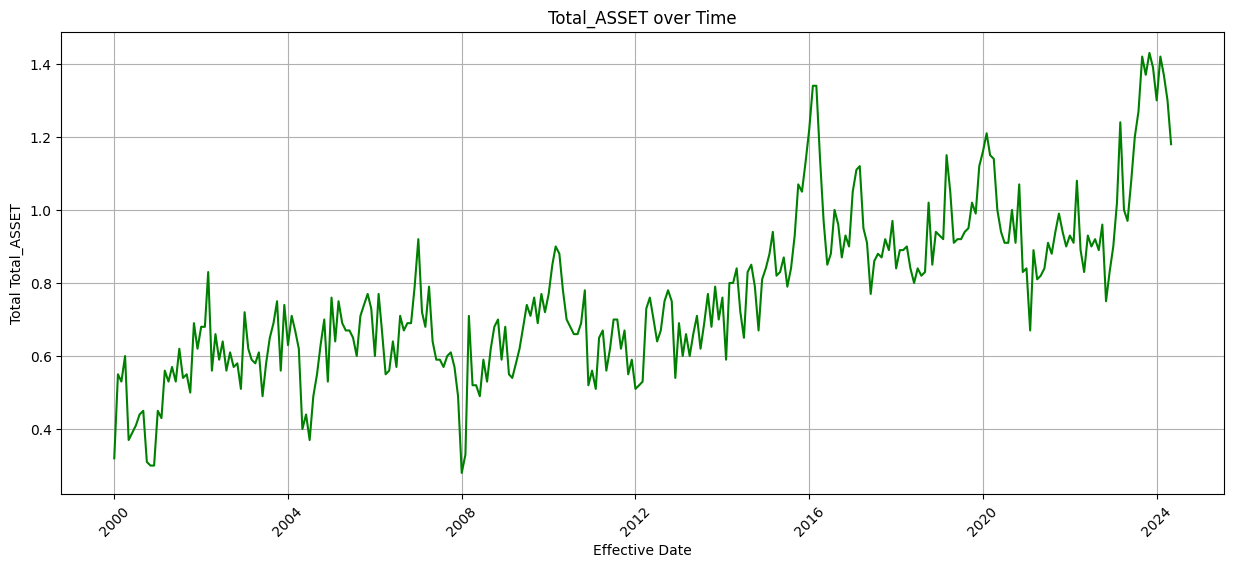

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Anomaly'],  linestyle='-',color='green')
plt.xlabel('Effective Date')
plt.ylabel('Total Total_ASSET')
plt.title('Total_ASSET over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [55]:
DF_Test=df.tail(7)

df=df.loc[df['Date']<='2024-05-21']

In [56]:
df.set_index('Date', inplace=True)

df.head()

,Anomaly
Date,
2000-01-01,0.32
2000-02-01,0.55
2000-03-01,0.53
2000-04-01,0.60
2000-05-01,0.37


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 1800 to 2092
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     293 non-null    datetime64[ns]
 1   Anomaly  293 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.9 KB


In [57]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Anomaly']])
validate_data = scaler.transform(valid[['Anomaly']])
test_data = scaler.transform(test[['Anomaly']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))


Train data size: 190
Validation data size: 60
Test data size: 43


In [58]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [59]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [60]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(5, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2683 - val_loss: 0.5311
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1476 - val_loss: 0.2827
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0614 - val_loss: 0.0954
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0197 - val_loss: 0.0245
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0272 - val_loss: 0.0244
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0206 - val_loss: 0.0378
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0182 - val_loss: 0.0534
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0206 - val_loss: 0.0506
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0197 - val_loss: 0.0406
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0188 - val_loss: 0.0330
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0168 - val_loss: 0.0350
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0147 - val_lo

In [20]:
model.save('cnn.h5')

In [61]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)
test_predict1 = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [62]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
test_predict1 = scaler.inverse_transform(test_predict1)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# MSE
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict1)

# RMSE
train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)

# MAE
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict1)

# R^2
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict1)

# Output
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train R²: {train_r2}')
print(f'Test R²: {test_r2}')


Train MSE: 0.015443274080128681
Test MSE: 0.02241280973616856
Train RMSE: 0.12427097038378948
Test RMSE: 0.1497090836795435
Train MAE: 0.09831152109197668
Test MAE: 0.1053107045198742
Train R²: 0.07819494836875807
Test R²: 0.4703275786097796


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


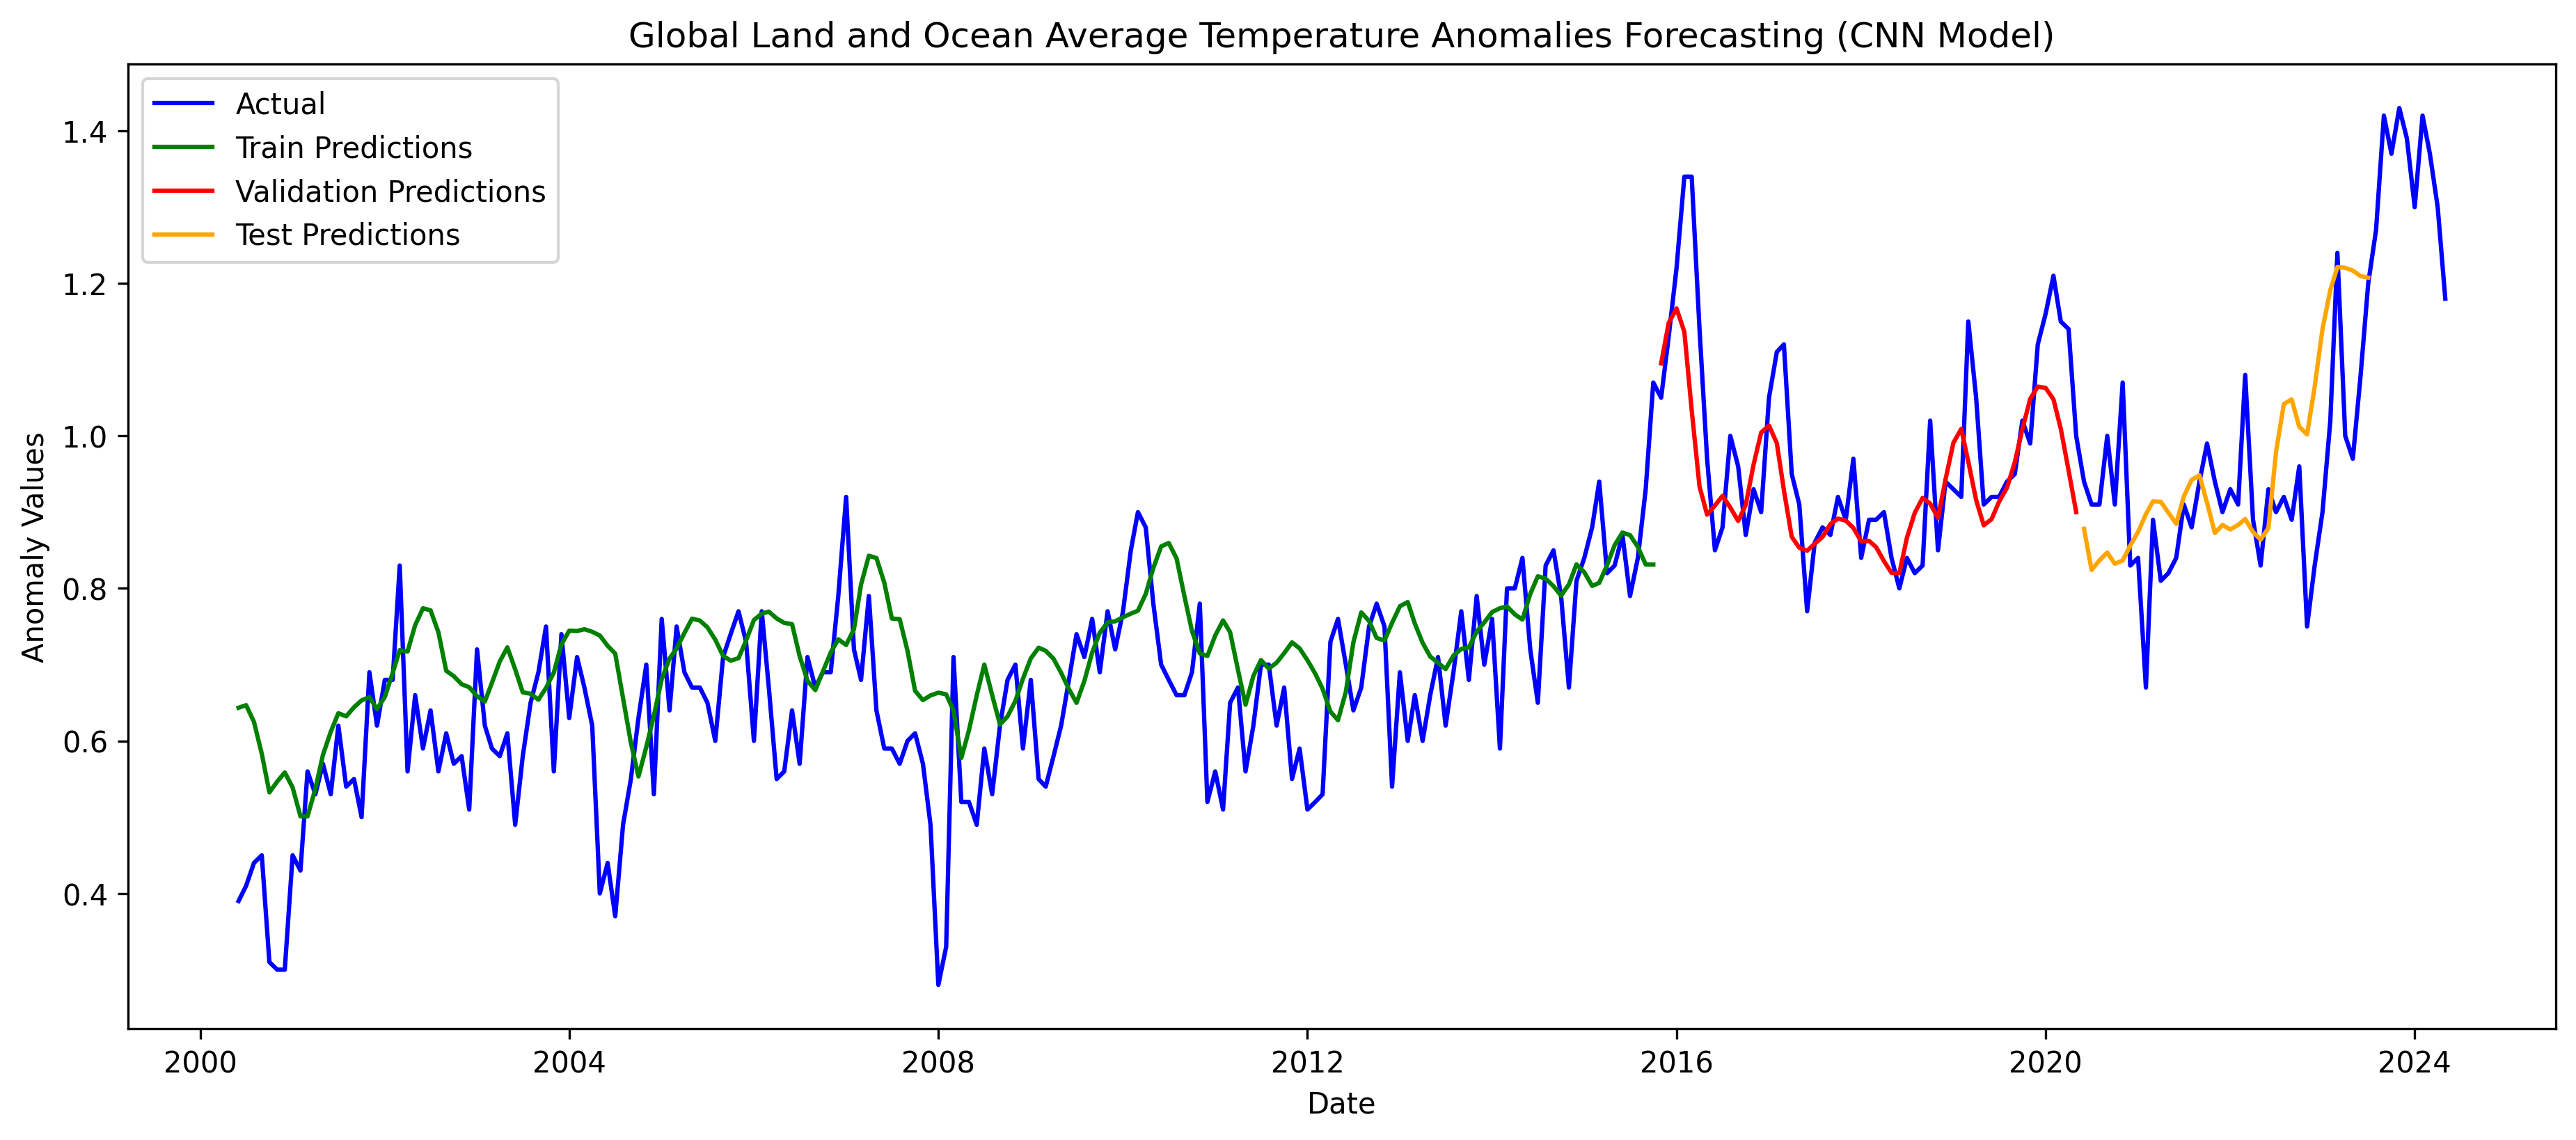

In [65]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
val_predictions = scaler.inverse_transform(val_predictions)


plt.figure(figsize=(15, 6),dpi=300)

plt.plot(df.index[seq_length:], df['Anomaly'][seq_length:], label='Actual', color='blue')

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')


val_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

test_pred_index = range(seq_length+len(train_predictions)+len(val_predictions), seq_length+len(train_predictions)+len(val_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

plt.title('Global Land and Ocean Average Temperature Anomalies Forecasting (CNN Model)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values')
plt.legend(loc='upper left')
plt.show()